In [1]:
import kagglehub
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
import warnings
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from skimage import color
import seaborn as sns
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)
img_size = (100, 100)
batch_size = 32

base_path = os.path.join(path, "fruits-360_dataset_100x100", "fruits-360")
train_dir = os.path.join(base_path, "Training")
test_dir = os.path.join(base_path, "Test")


Path to dataset files: C:\Users\raduf\.cache\kagglehub\datasets\moltean\fruits\versions\11


In [3]:
# Generatoare de date
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 70491 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


In [4]:
X_train = np.concatenate([train_generator[i][0] for i in range(len(train_generator))], axis=0)
print(X_train.shape)
X_test = np.concatenate([test_generator[i][0] for i in range(len(test_generator))], axis=0)
images, labels = train_generator[0]
class_names = list(train_generator.class_indices.keys())


(70491, 100, 100, 3)


In [5]:
y_train = np.concatenate([train_generator[i][1] for i in range(len(train_generator))], axis=0)
y_test = np.concatenate([test_generator[i][1] for i in range(len(test_generator))], axis=0)

In [6]:
Y_train_decimal = np.argmax(y_train, axis=1)
Y_test_decimal = np.argmax(y_test, axis=1)

In [7]:
pca = PCA(n_components=10)

X_test_flat = X_test.reshape(X_test.shape[0], -1)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_pca = pca.fit_transform(X_train_flat)

X_test_pca = pca.transform(X_test_flat)

In [8]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features, _ = hog(color.rgb2gray(img), orientations=6, pixels_per_cell=(16, 16),
                          cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

X_test_hog = extract_hog_features(X_test)


In [9]:
X_train_hog = extract_hog_features(X_train)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif

scaler = StandardScaler()

scaler.fit(X_train_pca)

x_train_pca_standardized = scaler.transform(X_train_pca)

x_test_pca_standardized = scaler.transform(X_test_pca)


scaler_hog = StandardScaler()
x_train_hog_standardized = scaler_hog.fit_transform(X_train_hog)
x_test_hog_standardized = scaler_hog.transform(X_test_hog)

x_train_combined = np.hstack((x_train_pca_standardized, x_train_hog_standardized))
x_test_combined = np.hstack((x_test_pca_standardized, x_test_hog_standardized))

variance_threshold = VarianceThreshold(threshold=1)
x_train_variance = variance_threshold.fit_transform(x_train_combined)
x_test_variance = variance_threshold.transform(x_test_combined)

print("Dimensiuni înainte și după Variance Threshold:")
print(f"Dimensiuni train înainte: {x_train_combined.shape}, după: {x_train_variance.shape}")
print(f"Dimensiuni test înainte: {x_test_combined.shape}, după: {x_test_variance.shape}")

Dimensiuni înainte și după Variance Threshold:
Dimensiuni train înainte: (70491, 226), după: (70491, 112)
Dimensiuni test înainte: (23619, 226), după: (23619, 112)


# Functie de antrenare

In [33]:
def train_model(model, train_loader, test_loader, num_epochs=20, lr=0.00001, optimizer=None, scheduler=None):
    criterion = nn.CrossEntropyLoss()
    if (optimizer == None):
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)

    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)
        if scheduler is not None:
            scheduler.step()
        # Testing
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_losses.append(running_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs},\n Train Loss: {train_losses[-1]:.4f},\n Test Loss: {test_losses[-1]:.4f}, "
              f"\nTrain Acc: {train_accuracies[-1]:.4f},\n Test Acc: {test_accuracies[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies, device

# 3.1

In [12]:
y_train = Y_train_decimal
y_test = Y_test_decimal

In [13]:


x_train_tensor = torch.Tensor(x_train_variance)
x_test_tensor = torch.Tensor(x_test_variance)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_sizes)
        self.fc2 = nn.Linear(hidden_sizes, hidden_sizes)
        self.fc3 = nn.Linear(hidden_sizes, output_size)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


input_size = x_train_variance.shape[1]
hidden_sizes = 100
output_size = 141


cuda
Epoch 1/20,
 Train Loss: 4.9248,
 Test Loss: 4.8999, 
Train Acc: 0.0154,
 Test Acc: 0.0164
Epoch 2/20,
 Train Loss: 4.8485,
 Test Loss: 4.8132, 
Train Acc: 0.0407,
 Test Acc: 0.0431
Epoch 3/20,
 Train Loss: 4.7223,
 Test Loss: 4.6747, 
Train Acc: 0.0692,
 Test Acc: 0.0671
Epoch 4/20,
 Train Loss: 4.5386,
 Test Loss: 4.4887, 
Train Acc: 0.0869,
 Test Acc: 0.0769
Epoch 5/20,
 Train Loss: 4.3086,
 Test Loss: 4.2668, 
Train Acc: 0.1004,
 Test Acc: 0.0876
Epoch 6/20,
 Train Loss: 4.0546,
 Test Loss: 4.0360, 
Train Acc: 0.1166,
 Test Acc: 0.1039
Epoch 7/20,
 Train Loss: 3.8056,
 Test Loss: 3.8188, 
Train Acc: 0.1476,
 Test Acc: 0.1391
Epoch 8/20,
 Train Loss: 3.5730,
 Test Loss: 3.6185, 
Train Acc: 0.1895,
 Test Acc: 0.1779
Epoch 9/20,
 Train Loss: 3.3564,
 Test Loss: 3.4343, 
Train Acc: 0.2465,
 Test Acc: 0.2294
Epoch 10/20,
 Train Loss: 3.1551,
 Test Loss: 3.2668, 
Train Acc: 0.3098,
 Test Acc: 0.2724
Epoch 11/20,
 Train Loss: 2.9705,
 Test Loss: 3.1162, 
Train Acc: 0.3643,
 Test Acc:

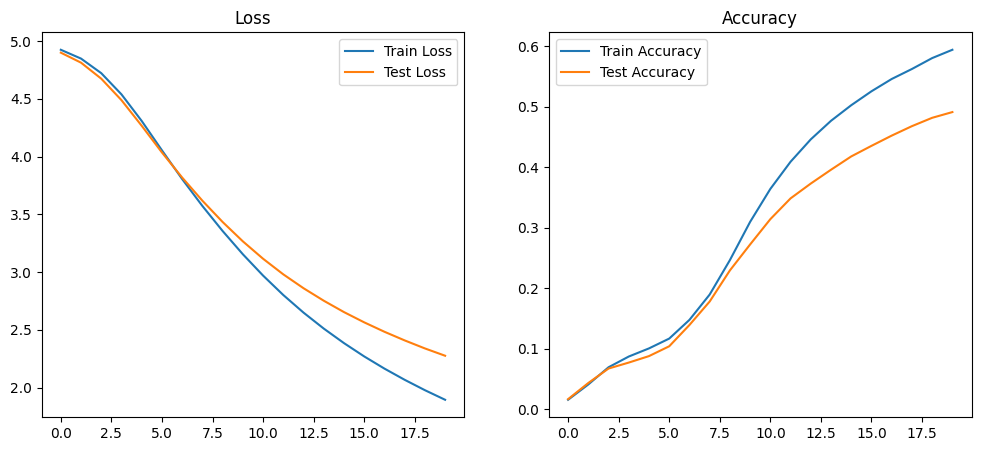

In [15]:
model = MLP(input_size, hidden_sizes, output_size)
train_losses, test_losses, train_accuracies, test_accuracies, device = train_model(model, train_loader, test_loader, num_epochs=20, lr=0.00001)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

              precision    recall  f1-score   support

          51       0.98      0.92      0.95       328
         112       0.69      0.83      0.76       304
         137       1.00      0.97      0.98       249
          31       0.81      0.63      0.71       246
          32       1.00      0.49      0.66       246
          75       0.92      0.35      0.51       246
          88       0.94      0.83      0.88       246
         125       0.65      0.36      0.46       246
         128       0.91      0.57      0.70       246
         130       0.79      0.33      0.46       246

   micro avg       0.86      0.64      0.74      2603
   macro avg       0.87      0.63      0.71      2603
weighted avg       0.87      0.64      0.72      2603



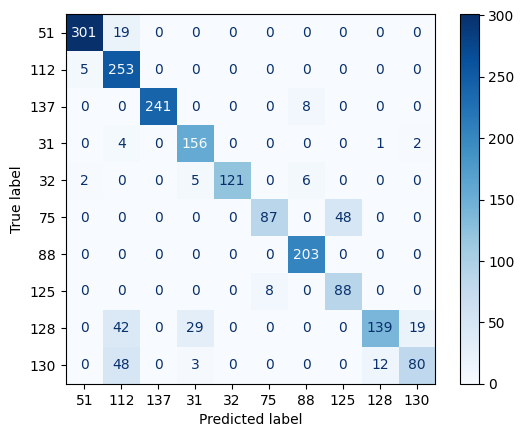

In [16]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from collections import Counter

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


top_10_classes = [item[0] for item in Counter(all_labels).most_common(10)]

filtered_preds = [pred for pred, label in zip(all_preds, all_labels) if label in top_10_classes]
filtered_labels = [label for label in all_labels if label in top_10_classes]

print(classification_report(filtered_labels, filtered_preds, labels=top_10_classes))
ConfusionMatrixDisplay.from_predictions(filtered_labels, filtered_preds, labels=top_10_classes, cmap='Blues')
plt.show()

# 3.2

In [7]:
x_train_tensor = torch.Tensor(X_train.reshape(X_train.shape[0], -1))
x_test_tensor = torch.Tensor(X_test.reshape(X_test.shape[0], -1))
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


input_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
hidden_sizes = 100


In [13]:
output_size = 141

model = MLP(input_size, hidden_sizes, output_size)
train_losses, test_losses, train_accuracies, test_accuracies, device = train_model(model, train_loader, test_loader, num_epochs=30, lr=0.00001)



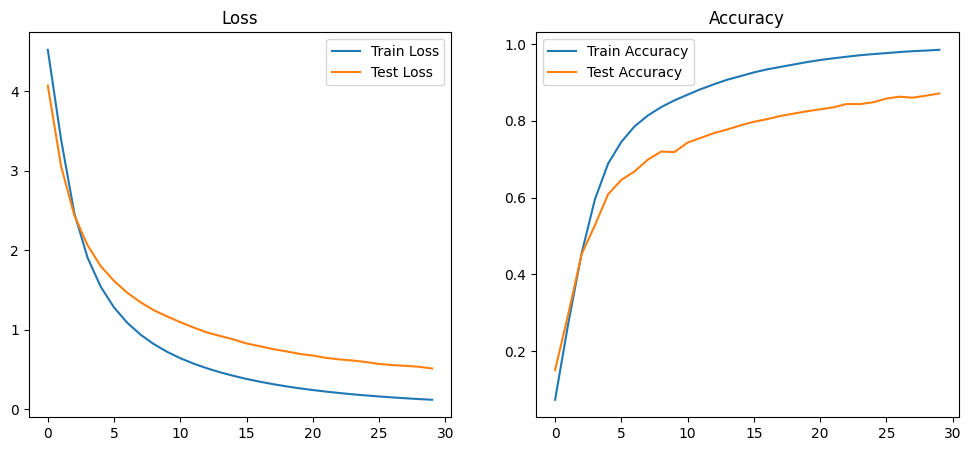

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from collections import Counter

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# print(classification_report(all_labels, all_preds))
# ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, cmap='Blues')
# plt.show()

top_10_classes = [item[0] for item in Counter(all_labels).most_common(10)]

filtered_preds = [pred for pred, label in zip(all_preds, all_labels) if label in top_10_classes]
filtered_labels = [label for label in all_labels if label in top_10_classes]

print(classification_report(filtered_labels, filtered_preds, labels=top_10_classes))
ConfusionMatrixDisplay.from_predictions(filtered_labels, filtered_preds, labels=top_10_classes, cmap='Blues')
plt.show()

# 3.3

In [34]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    """
    3x3 2D convolution with padding=1
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    @:param padding: the padding to apply, default is 1 to keep width and height the same in the output activation maps 
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """
    1x1 2D convolution
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [35]:
class ConvBlock(nn.Module):
    def __init__(self, bottleneck_channels, block_channels, norm_layer=nn.BatchNorm2d):
        super(ConvBlock, self).__init__()

        # first conv 1x1 layer which implements the bottlenecking
        self.conv1 = conv1x1(block_channels, bottleneck_channels)
        self.norm1 = norm_layer(bottleneck_channels)

        # conv 3x3 layer which applies the stride given as parameter
        self.conv2 = conv3x3(bottleneck_channels, bottleneck_channels)
        self.norm2 = norm_layer(bottleneck_channels)

        # conv 1x1 layer where the number of output channels is "expanded" according to the defined expansion factor
        # according to the above figure, the expansion factor is set to 4
        self.conv3 = conv1x1(bottleneck_channels, block_channels)
        self.norm3 = norm_layer(block_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        # first layer conv1 + bn1 + relu
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        # second layer conv2 + bn2 + relu
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)

        # third layer conv3 + bn3
        out = self.conv3(out)
        out = self.norm3(out)

        # add identity to residual and apply relu
        out += identity
        out = self.relu(out)

        return out



In [36]:
class DeepConvNet(nn.Module):
    def __init__(self, norm_layer=nn.BatchNorm2d, base_depth=16, expansion=4, nr_layer_blocks=3, num_classes=10):
        super(DeepConvNet, self).__init__()

        self.norm_layer = norm_layer
        self.base_depth = base_depth
        self.conv1 = nn.Conv2d(nr_layer_blocks, self.base_depth, kernel_size=7, stride=2, padding=3,
                               bias=False)  # image is now 16x16
        self.norm1 = norm_layer(self.base_depth)
        self.relu = nn.ReLU(inplace=True)

        # change to 64 channels base and image size 16x16
        depth1 = self.base_depth * expansion
        self.conv_depth1 = conv1x1(self.base_depth, depth1, stride=1)
        self.norm_depth1 = norm_layer(depth1)

        # #### Layer 1, 3 blocks
        self.layer1 = nn.Sequential(
            *[ConvBlock(self.base_depth, depth1, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # change to 128 channels base and image size 8x8
        depth2 = depth1 * 2
        # TODO 3.1 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        self.conv_depth2 = conv1x1(depth1, depth2)
        self.norm_depth2 = norm_layer(depth2)

        # #### Layer 2, 3 blocks
        # TODO 3.2 - Definiti secventa de ConvBlocks pentru Layer 2
        self.layer2 = nn.Sequential(
            *[ConvBlock(depth1, depth2, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # change to 256 chanels and image size 4x4
        depth3 = depth2 * 2
        # TODO 3.3 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        self.conv_depth3 = conv1x1(depth2, depth3)
        self.norm_depth3 = norm_layer(depth3)

        # Layer 3, 3 blocks
        # TODO 3.4 - Definiti secventa de ConvBlocks pentru Layer 3
        self.layer3 = nn.Sequential(
            *[ConvBlock(depth2, depth3, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # AveragePooling
        # TODO 3.5 - Definiti straturile de GlobalAveragePooling si stratul Fully Connected
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        # initial conv
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        # TODO 3.6 apply depth1 transform + layer 1
        x = self.layer1(self.norm_depth1(self.conv_depth1(x)))
        #am adaugat dropout
        x = self.dropout(x)
        # TODO 3.7 apply depth2 transform + layer 2
        x = self.layer2(self.norm_depth2(self.conv_depth2(x)))

        # TODO 3.8 apply depth3 transform + layer 3
        x = self.layer3(self.norm_depth3(self.conv_depth3(x)))

        # apply global average pooling + linearize + FC
        x = self.avgpool(x)
        x=x.view(-1, 256)
        x=self.fc(x)

        return x

In [45]:

x_train_tensor = torch.Tensor(X_train).permute(0, 3, 1, 2)
x_test_tensor = torch.Tensor(X_test).permute(0, 3, 1, 2)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [ ]:
model = DeepConvNet(num_classes=10)
train_losses2, test_losses2, train_accuracies2, test_accuracies2, device = train_model(model, train_loader, test_loader, num_epochs=20, lr=0.001)



In [40]:
import torchvision
import torchvision.transforms as transforms

DATA_MEAN = (0.5, 0.5, 0.5)
DATA_STD = (0.5, 0.5, 0.5)


train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(                        
            size=(28, 28), 
            padding=(4, 4), 
            padding_mode="reflect"),
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEAN, DATA_STD)
])


test_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),                         
        transforms.Normalize(DATA_MEAN, DATA_STD) 
    ] 
)

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
model = DeepConvNet(num_classes=10)
train_losses, test_losses, train_accuracies, test_accuracies, device = train_model(model, train_loader, test_loader, num_epochs=20, lr=0.001)

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses2, label='Train Loss')
plt.plot(test_losses2, label='Test Loss')
plt.plot(train_losses, label='Train Loss with Augmentation')
plt.plot(test_losses, label='Test Loss with Augmentation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies2, label='Train Accuracy')
plt.plot(test_accuracies2, label='Test Accuracy')
plt.plot(train_accuracies, label='Train Accuracy with Augmentation')
plt.plot(test_accuracies, label='Test Accuracy with Augmentation')
plt.title('Accuracy')
plt.legend()

plt.show()

cuda
Epoch 1/30,
 Train Loss: 4.2096,
 Test Loss: 3.6015, 
Train Acc: 0.1480,
 Test Acc: 0.2401
Epoch 2/30,
 Train Loss: 2.9120,
 Test Loss: 2.2972, 
Train Acc: 0.4036,
 Test Acc: 0.6131
Epoch 3/30,
 Train Loss: 1.3725,
 Test Loss: 0.7428, 
Train Acc: 0.8587,
 Test Acc: 0.9544
Epoch 4/30,
 Train Loss: 0.3102,
 Test Loss: 0.2394, 
Train Acc: 0.9958,
 Test Acc: 0.9807
Epoch 5/30,
 Train Loss: 0.0964,
 Test Loss: 0.1537, 
Train Acc: 1.0000,
 Test Acc: 0.9837
Epoch 6/30,
 Train Loss: 0.0529,
 Test Loss: 0.1262, 
Train Acc: 1.0000,
 Test Acc: 0.9835
Epoch 7/30,
 Train Loss: 0.0357,
 Test Loss: 0.1116, 
Train Acc: 1.0000,
 Test Acc: 0.9833
Epoch 8/30,
 Train Loss: 0.0268,
 Test Loss: 0.1027, 
Train Acc: 1.0000,
 Test Acc: 0.9843
Epoch 9/30,
 Train Loss: 0.0211,
 Test Loss: 0.0965, 
Train Acc: 1.0000,
 Test Acc: 0.9836
Epoch 10/30,
 Train Loss: 0.0174,
 Test Loss: 0.0925, 
Train Acc: 1.0000,
 Test Acc: 0.9837
Epoch 11/30,
 Train Loss: 0.0157,
 Test Loss: 0.0930, 
Train Acc: 1.0000,
 Test Acc:

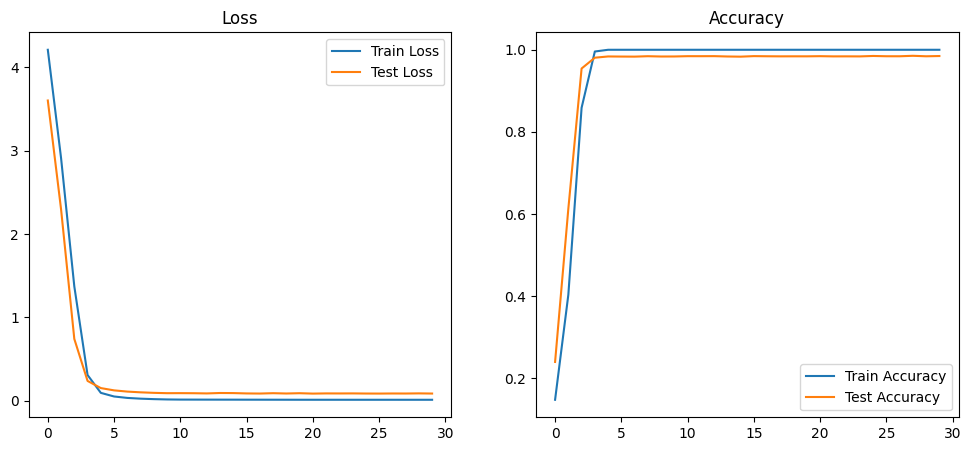

In [8]:
from cifar10_models.resnet import resnet18
import torchvision
import torchvision.transforms as transforms

model = resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 141)

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
DATA_MEAN = (0.5, 0.5, 0.5)
DATA_STD = (0.5, 0.5, 0.5)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEAN, DATA_STD)
])


train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

train_losses, test_losses, train_accuracies, test_accuracies, device = train_model(model, train_loader, test_loader, num_epochs=30, lr=0.0001, optimizer=optimizer, scheduler=scheduler)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


              precision    recall  f1-score   support

           0       0.69      1.00      0.82       157
           1       1.00      0.98      0.99       164
           2       1.00      1.00      1.00       148
           3       1.00      1.00      1.00       160
           4       1.00      1.00      1.00       164
           5       0.89      1.00      0.94       161
           6       1.00      0.99      0.99       164
           7       0.88      1.00      0.94       152
           8       1.00      1.00      1.00       164
           9       1.00      1.00      1.00       164
          10       1.00      1.00      1.00       144
          11       1.00      1.00      1.00       166
          12       1.00      1.00      1.00       164
          13       1.00      1.00      1.00       219
          14       0.90      1.00      0.95       234
          15       1.00      1.00      1.00       164
          16       1.00      1.00      1.00       143
          17       1.00    

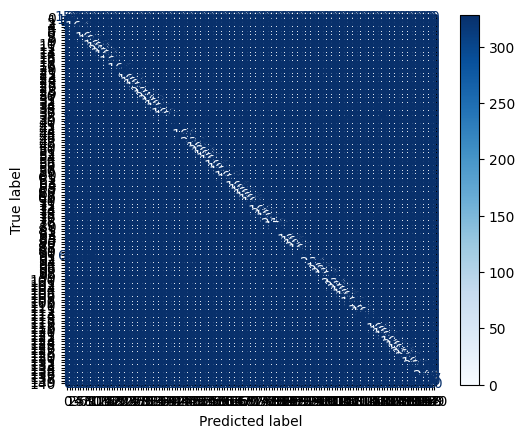

              precision    recall  f1-score   support

          51       1.00      1.00      1.00       328
         112       1.00      1.00      1.00       304
         137       1.00      1.00      1.00       249
          31       1.00      1.00      1.00       246
          32       1.00      1.00      1.00       246
          75       1.00      1.00      1.00       246
          88       1.00      1.00      1.00       246
         125       1.00      0.99      0.99       246
         128       1.00      1.00      1.00       246
         130       1.00      1.00      1.00       246

   micro avg       1.00      1.00      1.00      2603
   macro avg       1.00      1.00      1.00      2603
weighted avg       1.00      1.00      1.00      2603



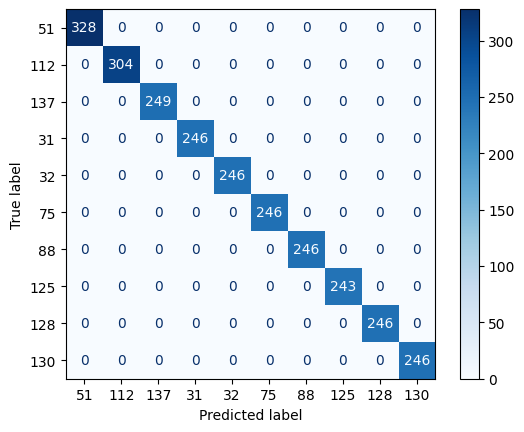

In [10]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from collections import Counter

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, cmap='Blues')
plt.show()

top_10_classes = [item[0] for item in Counter(all_labels).most_common(10)]

filtered_preds = [pred for pred, label in zip(all_preds, all_labels) if label in top_10_classes]
filtered_labels = [label for label in all_labels if label in top_10_classes]

print(classification_report(filtered_labels, filtered_preds, labels=top_10_classes))
ConfusionMatrixDisplay.from_predictions(filtered_labels, filtered_preds, labels=top_10_classes, cmap='Blues')
plt.show()